In [ ]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Dense

from scipy import sparse
from utils import text_preprocessing, create_unique_word_dict

In [2]:
filename = 'random_text.txt'
lines = open(filename).read().split('\n')

In [3]:
texts = [x for x in lines if x]

In [4]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

770it [00:00, 227453.63it/s]


In [5]:
# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X).todense()
Y = sparse.csr_matrix(Y).todense()

# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )    


Epoch 1/1000
4/4 [==============================] - 1s 8ms/step - loss: 4.9060
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.9042
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 4.9027
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 4.9012
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 4.8998
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.8984
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.8971
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.8958
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 4.8946
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.8933
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 4.8921
Epoch 12/1000
4/4 [==============================] - 0s 3ms/step - loss: 4.8909
Epoch 13/1000
4/4 [==============================

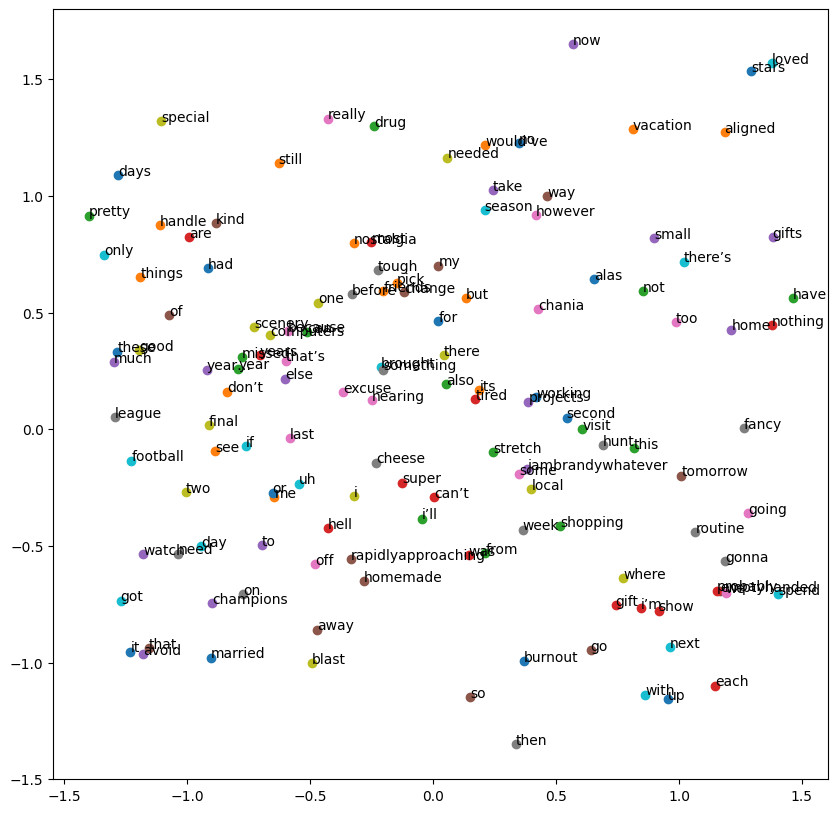

In [7]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}/output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}/output/embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}')         